# Deep Neural Network 구현하기
jhbale11

[Coursera]Andrew Ng 's Deep Learning Lecture

https://github.com/suqi/deeplearning_andrewng

앤드류 응 교수님의 딥러닝 강의를 듣고 예제를 제 방식대로 연습한 결과입니다.

# Load Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils_123 import load_dataset, plot_decision_boundary, load_planar_dataset

plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
train_set_x_orig, train_y, test_set_x_orig, test_y, classes = load_dataset()
train_set_x_flatten = train_set_x_orig.reshape(-1, 64*64*3).T
test_set_x_flatten = test_set_x_orig.reshape(-1, 64*64*3).T
train_x = train_set_x_flatten/255.
test_x = test_set_x_flatten/255.
print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


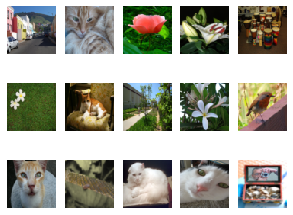

In [3]:
# 데이터는 1장에서 사용한 것과 같습니다.
for i in range(1, 16):
    plt.subplot(3,5,i)
    plt.imshow(train_set_x_orig[i])
    plt.axis('off')
plt.show()

## 개요 
L개의 Layer를 사용한 Neural Network를 만들어 볼 것입니다.
순전파 모듈과 역전파 모듈의 원리를 이해하고 구현할 것입니다.

Here is an outline of this assignment, you will:

- Initialize the parameters for a two-layer network and for an $L$-layer neural network.
- Implement the forward propagation module (shown in purple in the figure below).
    - Complete the LINEAR part of a layer's forward propagation step (resulting in  Z[l] ).
    - We give you the ACTIVATION function (relu/sigmoid).
    - Combine the previous two steps into a new [LINEAR->ACTIVATION] forward function.
    - Stack the [LINEAR->RELU] forward function L-1 time (for layers 1 through L-1) and add a [LINEAR->SIGMOID] at the end (for the final layer  L ). This gives you a new L_model_forward function.
    
- Compute the loss.
- Implement the backward propagation module (denoted in red in the figure below).
    - Complete the LINEAR part of a layer's backward propagation step.
    - We give you the gradient of the ACTIVATE function (relu_backward/sigmoid_backward)
    - Combine the previous two steps into a new [LINEAR->ACTIVATION] backward function.
    - Stack [LINEAR->RELU] backward L-1 times and add [LINEAR->SIGMOID] backward in a new L_model_backward function
- Finally update the parameters.

**Note** that for every forward function, there is a corresponding backward function. That is why at every step of your forward module you will be storing some values in a cache. The cached values are useful for computing gradients. In the backpropagation module you will then use the cache to calculate the gradients. 

![](https://datascience-enthusiast.com/figures/finaloutline.png)

In [4]:
# 활성화함수 정의. 순전파의 캐시값은 역전파 때 사용합니다.
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    return A

def relu(Z):
    A = np.maximum(0, Z)
    return A

def sigmoid_backward(dA, Z):
    A = 1 / (1+np.exp(-Z))
    dZ = dA * A * (1 - A)
    return dZ

def relu_backward(dA, Z):
    dA[Z<=0] = 0
    return dA

# 1. 가중치 초기화. 층별 유닛 개수를 받아서 초기 가중치를 반환합니다.
def initialize_parameters_deep(layer_dims):
    parameters = {}
    for i in range(1, len(layer_dims)):
        parameters["W" + str(i)] = np.random.randn(layer_dims[i], layer_dims[i-1]) / np.sqrt(layer_dims[i-1])
        parameters["b" + str(i)] = np.zeros((layer_dims[i], 1))    
    return parameters

In [5]:
# 2. 순전파
def linear_forward(A_prev, W, b):
    Z = np.dot(W, A_prev) + b
    linear_cache = (A_prev, W)
    return Z, linear_cache

def linear_activation_forward(A_prev, W, b, activation):
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A = sigmoid(Z)
    elif activation == 'relu':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A = relu(Z)
    cache = (linear_cache, Z)   
    return A, cache

def L_model_forward(X, parameters): 
    layer_num = len(parameters)//2
    caches = []
    
    for l in range(1, layer_num):
        W = parameters['W' + str(l)] 
        b = parameters['b' + str(l)]
        X, cache = linear_activation_forward(X, W, b, activation='relu')
        caches.append(cache)    
    
    W = parameters['W' + str(layer_num)] 
    b = parameters['b' + str(layer_num)]
    AL, cache = linear_activation_forward(X, W, b, activation='sigmoid')
    caches.append(cache)
    
    return AL, caches

In [6]:
# 3. 손실값 계산
def compute_cost(AL, Y):    
    cost = -np.mean((np.log(AL) * Y) + (np.log(1-AL) * (1 - Y)))
    return cost

# 4. 역전파
def linear_backward(dZ, linear_cache):
    
    A_prev, W = linear_cache
    m = dZ.shape[1]
    dA_prev = np.dot(W.T, dZ) 
    dW = np.dot(dZ, A_prev.T) / m
    db = np.mean(dZ, axis=1, keepdims=True)
    
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    linear_cache, Z = cache
    
    if activation == 'relu':
        dZ = relu_backward(dA, Z)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    elif activation == 'sigmoid':
        dZ = sigmoid_backward(dA, Z)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches):
    
    dA = -np.divide(Y, AL) + np.divide(1-Y, 1-AL)
    m = AL.shape[1]
    L = len(caches)
    grads = {}
    
    dA, dW, db = linear_activation_backward(dA, caches[-1], activation='sigmoid')
    grads['dA' + str(L-1)] = dA
    grads['dW' + str(L)] = dW
    grads['db' + str(L)] = db
        
    for l in reversed(range(L-1)):
        cache = caches[l]
        dA, dW, db = linear_activation_backward(dA, cache, activation='relu')
        grads['dA' + str(l)] = dA
        grads['dW' + str(l+1)] = dW
        grads['db' + str(l+1)] = db

    return grads

# 5. 가중치 갱신
def update_parameters(parameters, grads, learning_rate):
    
    L = len(parameters) // 2
    for l in range(L):
        parameters['W' + str(l+1)] -= learning_rate * grads['dW' + str(l+1)]
        parameters['b' + str(l+1)] -= learning_rate * grads['db' + str(l+1)]
    return parameters

이제 모든 걸 하나로 합쳐서 모델을 구현합니다.

1) 순전파
2) 손실값 계산
3) 역전파

의 순으로 붙여서 모델을 완성합니다.

In [7]:
def L_layer_model(X, Y, layers_dims, X_val=None, Y_val=None, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    costs = []
    val_costs = []
    parameters = initialize_parameters_deep(layers_dims)
    
    for l in range(1,num_iterations+1):
        # 순전파 (훈련셋)
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        costs.append(cost)
        
        # 순전파 (검증셋)
        if X_val is not None:
            AL_val, _ = L_model_forward(X_val, parameters)
            val_cost = compute_cost(AL_val, Y_val)
            val_costs.append(val_cost)            
            if print_cost and l%100==0:
                print('#%d cost:' %(l//100), round(cost, 4), end=' ')
                print('val_cost', round(val_cost, 4))                        
        elif print_cost and l%100==0:
            print('#%d cost:' %(l//100), round(cost, 4))
        
        # 역전파
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        
    # plot the cost
    plt.plot(costs, label='Training cost')
    plt.plot(val_costs, label='Validation cost')
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.legend()
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

## 고양이 이미지 데이터에 적용

In [8]:
def predict(X, parameters):
    AL, _ = L_model_forward(X, parameters)
    return np.where(AL>0.5, 1, 0)
def accuracy(y_true, y_pred):
    return round((1 - np.mean(np.abs(y_pred - y_true)) )*100, 3)

#### 은닉층이 없는 단순한 로지스틱 회귀

#1 cost: 0.5346 val_cost 0.7034
#2 cost: 0.4743 val_cost 0.6556
#3 cost: 0.4321 val_cost 0.6327
#4 cost: 0.3992 val_cost 0.6208
#5 cost: 0.3722 val_cost 0.6149
#6 cost: 0.3493 val_cost 0.6126
#7 cost: 0.3295 val_cost 0.6127
#8 cost: 0.3122 val_cost 0.6144


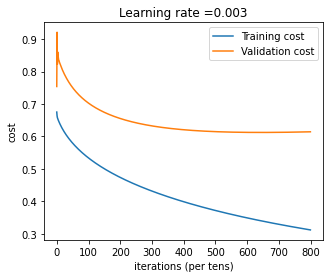

train accuracy: 91.388 %
validation accuracy: 70.0 %


In [9]:
layers_dims = [64*64*3, 1]
parameters = L_layer_model(train_x, train_y, layers_dims, test_x, test_y, 
                           learning_rate = 0.003, num_iterations = 800, print_cost=True)
print("train accuracy: {} %".format(accuracy(predict(train_x, parameters), train_y)))
print("validation accuracy: {} %".format(accuracy(predict(test_x, parameters), test_y)))

#### 은닉층을 추가한 다층 신경망

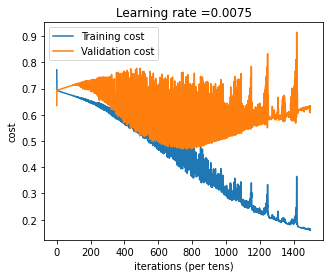

train accuracy: 98.086 %
validation accuracy: 82.0 %


In [10]:
layers_dims = [64*64*3, 20, 7, 5, 1]
np.random.seed(1)
parameters = L_layer_model(train_x, train_y, layers_dims, test_x, test_y,
                           learning_rate = 0.0075, num_iterations = 1500, print_cost=False)
print("train accuracy: {} %".format(accuracy(predict(train_x, parameters), train_y)))
print("validation accuracy: {} %".format(accuracy(predict(test_x, parameters), test_y)))

은닉층을 여러 개 쌓음으로써 정확도를 12% 가량 상승시킬 수 있었습니다! <br>

그러나 가중치 초기값과 학습률에 크게 영향을 받았으며, 이에 따라 랜덤 시드에 의해서도 성능 차이가 눈에 띌 정도였음도 확인할 수 있었습니다.

## 숫자 이미지 데이터에 적용

In [11]:
from sklearn.datasets import load_digits # 전처리 과정은 1장과 동일.
data = load_digits()
data_x, data_y = data['images'], data['target']
index = np.random.permutation(data_x.shape[0])
data_x_shuffled = data_x[index]
data_y_shuffled = data_y[index]
data_x_flattend = data_x_shuffled.reshape(-1,8*8).T / 16
data_y_flattend = data_y_shuffled.reshape(1,-1)
data_y_flattend_binary = np.where(data_y_flattend%2==0,0,1)
test_size = round(data_x_flattend.shape[1] * 0.2)
X_train = data_x_flattend[:, test_size:] 
X_test = data_x_flattend[:, :test_size] 
y_train = data_y_flattend_binary[:,test_size:]
y_test = data_y_flattend_binary[:,:test_size]

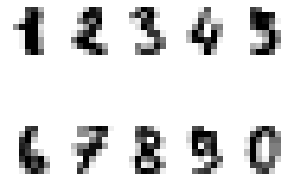

In [12]:
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(data_x[i], cmap='binary')
    plt.axis('off')
plt.show()

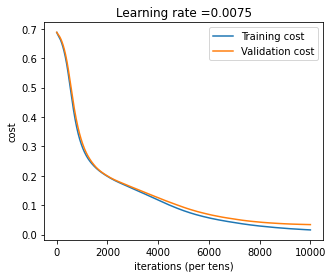

train accuracy: 99.791 %
validation accuracy: 98.886 %


In [13]:
layers_dims = [64, 20, 7, 5, 1]
np.random.seed(1)
parameters = L_layer_model(X_train, y_train, layers_dims, X_test, y_test,
                           learning_rate = 0.0075, num_iterations = 10000, print_cost=False)
print("train accuracy: {} %".format(accuracy(predict(X_train, parameters), y_train)))
print("validation accuracy: {} %".format(accuracy(predict(X_test, parameters), y_test)))